### ECON 210C: PSET 1 
### Complementarity of Money and Consumption
Written by: Zorah Zafari (zzafari@ucsd.edu) (in collaboration with many classmates)

#### We have three blocks 

1. Firm Block
\begin{equation}
 \hat{y_t} = \hat{a_t} + \hat{n_t}
\end{equation}

\begin{equation}
 \hat{w_t} - \hat{p_t} = \hat{a_t}
\end{equation}

2. Household Block
\begin{equation}
\hat{c_t} = \left[ (\nu-\gamma)(1-\vartheta) \left( \frac{C}{X}\right)^{1-\nu} - \nu \right]^{-1} 
[\varphi \hat{n_t}-(\nu - \gamma)\vartheta\left( \frac{M}{P} \right) (\hat{m_t} = \hat{p_t}) - (\hat{w_t} - \hat{p_t})]
\end{equation}


3. Market Clearning

\begin{equation}
 \hat{y_t} = \hat{c_t}
\end{equation}

\begin{equation}
 (\hat{m_t} - \hat{p_t}) =  \hat{c_t} - \frac{1}{\nu} \frac{\beta}{1-\beta}\hat{q_t}
\end{equation}


#### We have 7 variables: 

Endogenous variables: $y, c, w, q, x$

Exogenous variables: $m$ (nominal money) ( A is also exogenous but it is equal to 1) 

Unknown variables: n


#### The equilibrium is a solution to an equation:

$$
H(U,Z)= 0 
$$

Where $U$ is the time path $(U_{0}, U_{1},...)$ of unknown aggregate sequences (e.g. quantities or prices) and $Z$ represents the time path $(Z_{0}, Z_{1},...)$ of exogenous shocks. 

#### We need to differentiate and evaluate at steady state to get: 
$$
H(U,Z) = 0 
$$ 
$$
H_{U}dU + H_{Z}dZ = 0 
$$ 
$$ dU = -H_{U}(\bar{U}, \bar{Z})^{-1}H_{Z}(\bar{U},\bar{Z})dZ 
$$

#### Solutions then requite finding the sequence-space Jacobians : $H_{U}$ and $H_{Z}$

$$ 
\frac{\partial H}{\partial U} =  \frac{\partial H}{\partial Y} * \frac{\partial Y}{\partial U} 
$$

$$ 
\frac{\partial H}{\partial Z} =  \frac{\partial H}{\partial Y} * \frac{\partial Y}{\partial Z} 
$$




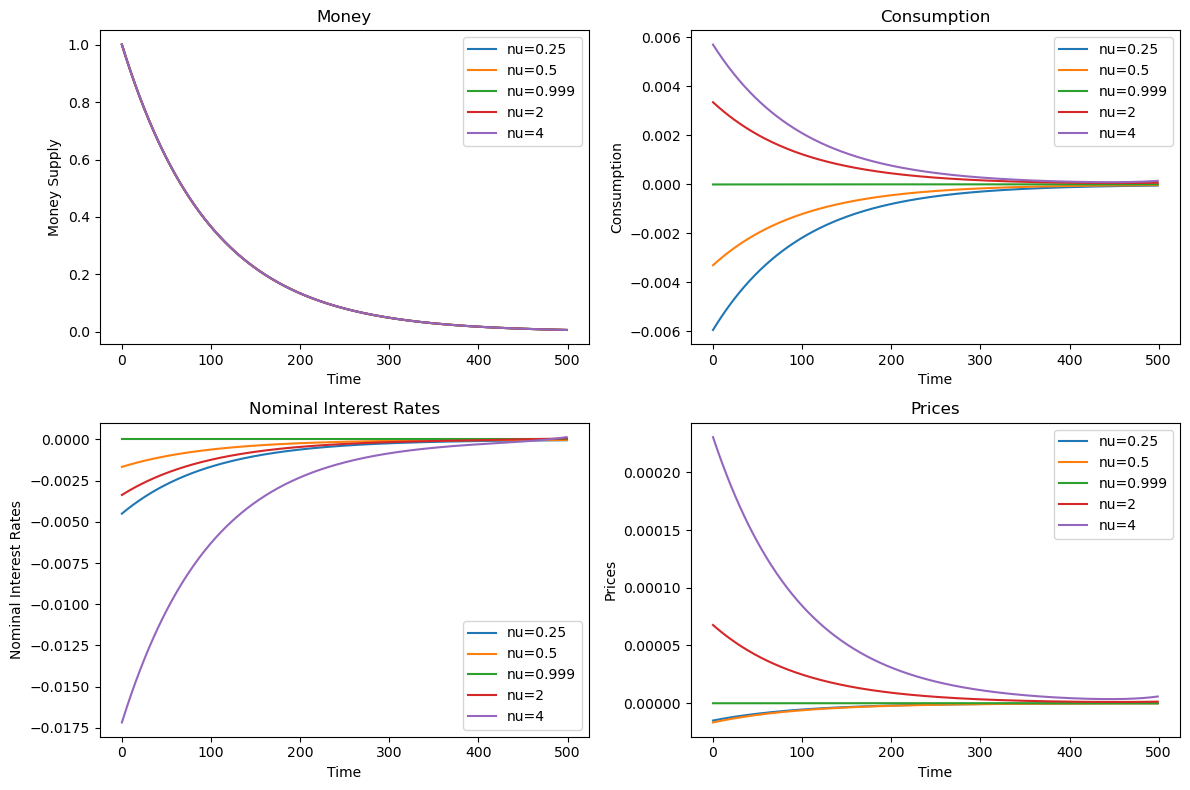

In [4]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg
import matplotlib.pyplot as plt

# Parameters
gamma = 1
varphi = 1
chi = 1
beta = 0.99
rho_m = 0.99
A = 1
T = 500

# Calculate vartheta
nu_arr = [0.25, 0.5, 0.999, 2, 4]
vartheta_arr = []
for nu in nu_arr:
    vartheta = (1 - beta) / ((1 - beta) + ((-(1 - beta) + np.sqrt(beta**2 - 2*beta + 5)) / 2)**nu)
    vartheta_arr.append(vartheta)

# Steady State and Model Setup
I = sp.eye(T)
Ip1 = sp.diags([np.ones(T-1)], [1], (T, T))
Im1 = sp.diags([np.ones(T-1)], [-1], (T, T))
Z = sp.csr_matrix((T, T))

# Record c, p, q IRFs
C, P, Q, M = [], [], [], []

for i in range(len(nu_arr)):
    nu = nu_arr[i]
    vartheta = vartheta_arr[i]

    # Steady State
    c_ss = (
        chi**(-1/(nu - gamma)) *
        (1 - vartheta)**(1/(nu - gamma)) *
        (
            (1 - vartheta) +
            vartheta**(1/nu) *
            ((1 / ((1 - vartheta) * (1 - beta)))**((1 - nu) / nu))
        )**(1/(1 - nu))
    )**((nu - gamma) / (varphi + gamma))

    p_ss = 1

    m_ss = (
        (vartheta / ((1 - vartheta) * (1 - beta)))**(1/nu) *
        chi**(-1/(nu - gamma)) *
        (1 - vartheta)**(1/(nu - gamma)) *
        (
            (1 - vartheta) +
            vartheta**(1/nu) *
            ((1 / ((1 - vartheta) * (1 - beta)))**((1 - nu) / nu))
        )**(1/(1 - nu))
    )**((nu - gamma) / (varphi + gamma))

    x_ss = ((1 - nu) * c_ss**(1 - nu) + nu * (m_ss / p_ss)**(1 - nu))**(1/(1-nu))

    # Market clearing block: goods market clearing
    Phigmy = -I 
    Phigmc = I
    Phigmmp = Z
    Phigmx = Z 
    Phigmwp = Z
    Phigmq = Z 

    # Market clearing block: money market clearing  
    Phimmc = I 
    Phimmmp = -I 
    Phimmq = -(1/nu)*beta/(1-beta)*I
    Phimmy = Z 
    Phimmwp = Z
    Phimmx = Z 

    # Combine matrix blocks
    dHdY = sp.bmat([[Phigmy, Phigmwp, Phigmc, Phigmq],
                    [Phimmy, Phimmwp, Phimmc, Phimmq]])

    assert dHdY.shape == (2*T, 4*T)

    # Firm block matrices: output
    Phiyn = I
    Phiym = Z
    Phiyp = Z 

    # Firm block matrices: labor demand
    Phiwpn = Z
    Phiwpm = Z
    Phiwpp = I 

    # Combine firm matrices
    dYFdU = sp.bmat([[Phiyn, Phiyp],
                     [Phiwpn, Phiwpp]])

    dYFdZ = sp.bmat([[Phiym],
                     [Phiwpm]])

    assert dYFdU.shape == (2*T, 2*T)
    assert dYFdZ.shape == (2*T, T)

    # Household Block
    A = ((nu-gamma)*(1-vartheta)*(c_ss/x_ss)**(1-nu)-nu)**(-1)
    Phicm = -(1/A)*(vartheta*(m_ss/p_ss)**(1-nu)*(nu-gamma))*I - (1/A)*Phiwpm
    Phicn = (1/A)*varphi*I - (1/A)*Phiwpn
    Phicp = (1/A)*(vartheta*(m_ss/p_ss)**(1-nu)*(nu-gamma))*I - (1/A)*Phiwpp

    # Add the extra phi for the variable X
    Phixm = (1-vartheta)*(c_ss/x_ss)*Phicm
    Phixn = (1-vartheta)*(c_ss/x_ss)*Phicn
    Phixp = (1-vartheta)*(c_ss/x_ss)*Phicp

    dYHdU = sp.bmat([[Phicn, Phicp]])
    dYHdZ = sp.bmat([[Phicm]])
    assert dYHdU.shape == (T, 2*T)
    assert dYHdZ.shape == (T, T)

    # Bonds Block
    Phiqm = nu*Phicm*(I-Ip1) - (nu-gamma)*Phicm*(I-Ip1)
    Phiqn = nu*Phixn*(I-Ip1) - (nu - gamma)*Phixn*(I-Ip1)
    Phiqp = -(I-Ip1) + nu*Phicp*(I-Ip1) - (nu - gamma)*Phicp*(I-Ip1)

    dYBdU = sp.bmat([[Phiqn, Phiqp]])
    dYBdZ = sp.bmat([[Phiqm]])
    assert dYBdU.shape == (T, 2*T)
    assert dYBdZ.shape == (T, T)

    # Stack to get dYdU
    dYdU = sp.bmat([[dYFdU],
                    [dYHdU],
                    [dYBdU]])
        
    # Stack to get dYdZ
    dYdZ = sp.bmat([[dYFdZ],
                    [dYHdZ],
                    [dYBdZ]])
    
    assert dYdU.shape == (4*T, 2*T)
    assert dYdZ.shape == (4*T, T)

    # Compute dHdU and dHdZ using the chain rule
    dHdU = dHdY @ dYdU 
    dHdZ = dHdY @ dYdZ

    assert sp.issparse(dHdZ) == True
    assert sp.issparse(dHdU) == True

    assert dHdU.shape == (2*T, 2*T)
    assert dHdZ.shape == (2*T, T)

    # Compute the Jacobian of the model
    dUdZ = -sp.linalg.spsolve(dHdU, dHdZ)
    dYdZ = dYdU @ dUdZ + dYdZ

    dXdZ = sp.bmat([[dUdZ],
                    [dYdZ]])
    
    assert dUdZ.shape == (2*T, T)
    assert dYdZ.shape == (4*T, T)
    assert dXdZ.shape == (6*T, T)

    # Plot IRF for an AR(1) TFP shock with persistence rho
    # Plotting IRFs
    # plot IRFs to Money Supply shock with persistence rho
    rho_m = 0.99
    m = np.zeros((T, 1))
    m[0] = 1
    for t in range(1, T):
        m[t] = rho_m * m[t-1]

    # Compute impulse response functions
    X = dXdZ @ m

    # Unpack X into its components y, wp, c, q
    n = X[0:T]
    p = X[T:2*T]
    y = X[2*T:3*T]
    wp = X[3*T:4*T]
    c = X[4*T:5*T]
    q = X[5*T:6*T]

    # Record 
    C.append(c)
    P.append(p)
    Q.append(q)
    M.append(m)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot Money
for i in range(len(M)):
    axes[0, 0].plot(M[i], label='nu='+str(nu_arr[i]))
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Money Supply')
axes[0, 0].set_title('Money')
axes[0, 0].legend()

# Plot Consumption
for i in range(len(C)):
    axes[0, 1].plot(C[i], label='nu='+str(nu_arr[i]))
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Consumption')
axes[0, 1].set_title('Consumption')
axes[0, 1].legend()

# Plot Price
for i in range(len(P)):
    axes[1, 0].plot(P[i], label='nu='+str(nu_arr[i]))
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Nominal Interest Rates')
axes[1, 0].set_title('Nominal Interest Rates')
axes[1, 0].legend()

# Plot Nominal Interest Rate
for i in range(len(Q)):
    axes[1, 1].plot(Q[i], label='nu='+str(nu_arr[i]))
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Prices')
axes[1, 1].set_title('Prices')
axes[1, 1].legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

### Below are my solutions for parts (a)-(j)


Suppose the utility function in our classical monetary model is now

$$
    U(X_t,L_t)=\frac{X_t^{1-\gamma}-1}{1-\gamma}-\chi \frac{N_t^{1+\varphi}}{{1+\varphi}}
$$
where
$$
    X_t=\left[(1-\vartheta)C_t^{1-\nu}+\vartheta\left(\frac{M_t}{P_t}\right)^{1-\nu}\right]^{\frac{1}{1-\nu}}
$$

### (a) Derive the first order conditions for this economy.

#### The household solves the following optimization problem:

$$
\max\limits_{C_t, N_t, B_t, M_t} E_t \sum_{s=0}^\infty \beta^{t+s} (\frac{X_t^{1-\gamma}-1}{1-\gamma}-\chi \frac{N_t^{1+\varphi}}{{1+\varphi}})
$$

#### subject to 

$$ 
P_{t+s}C_{t+s} + B_{t+s} + M_{t+s} = W_{t+s} N_{t+s} + Q_{t+s-1} B_{t+s-1} + M_{t+s-1} + P_{t+s}(TR_{t+s} + PR_{t+s}) 
$$


#### Lagrangian:
$$
\begin{align*}
    \mathcal{L} &= \mathbb{E}_{t} \sum_{s=0}^\infty \beta^{t+s} \left[ \frac{X_{t+s}^{1-\gamma}-1}{1-\gamma} - \chi \frac{N_{t+s}^{1+\varphi}}{1+\varphi} \right. \\
    &\quad \left. + \lambda_{t+s} \left( W_{t+s} N_{t+s} + Q_{t+s-1} B_{t+s-1} + M_{t+s-1} + P_{t+s}(TR_{t+s} + PR_{t+s}) - P_{t+s}C_{t+s} - B_{t+s} - M_{t+s} \right) \right]
\end{align*}
$$

#### FOCs:
$$
\begin{align*}
    C_{t+s} : & \quad X_{t+s}^{\nu - \gamma}(1 - \vartheta)C_{t+s}^{-\nu} = P_{t+s} \lambda_{t+s} \\
    N_{t+s} : & \quad \chi N_{t+s}^\varphi = \lambda_{t+s} W_{t+s} \\
    B_{t+s} : & \quad \mathbb{E}_{t+s} \left[ \beta \lambda_{t+s+1} Q_{t+s} \right] = \lambda_{t+s} \\
    M_{t+s} : & \quad \mathbb{E}_{t+s} \left[ \beta \lambda_{t+s+1} \right] + X_{t+s}^{\nu-\gamma} \left( \frac{M_{t+s}}{P_{t+s}} \right)^{-\nu} \frac{1}{P_{t+s}} = \lambda_{t+s}
\end{align*}
$$

#### Eliminate $\lambda_{t}$ to get household FOCs:
1. labor–leisure equation:
$$
    \frac{W_{t+s}}{P_{t+s}} = \frac{\chi N_{t+s}^{\varphi}}{(1 - \vartheta)C_{t+s}^{-\nu} X_{t+s}^{\nu - \gamma}}
$$
2. Euler equation:
$$
    \frac{X_{t+s}^{\nu - \gamma} C_{t+s}^{-\nu}}{P_{t+s}} = \beta Q_{t+s} \mathbb{E}_{t+s} \left[ \frac{X_{t+s+1}^{\nu - \gamma} C_{t+s+1}^{-\nu}}{P_{t+s+1}} \right]
$$
3. money–consumption equation:
$$
    \frac{X_{t+s}^{\nu - \gamma} C_{t+s}^{-\nu}}{P_{t+s}} = \beta \mathbb{E}_{t+s} \left[ \frac{X_{t+s+1}^{\nu - \gamma} C_{t+s+1}^{-\nu}}{P_{t+s+1}} \right] + X_{t+s}^{\nu - \gamma} \frac{\vartheta}{1 - \vartheta} \left(\frac{M_{t+s}}{P_{t+s}}\right)^{-\nu} \frac{1}{P_{t+s}}
$$

#### Firm's problem: maximize profits $PR_t = Y_t - \frac{W_t}{P_t} N_t$ where $Y_t = A_t N_t$. \\

#### FOC:
$$
    \frac{\partial PR_t}{\partial N_t} = 0 = A_t - \frac{W_t}{P_t}
$$
#### Set the real wages equal to the marginal product of labor:
$$
    A_t = \frac{W_t}{P_t}
$$


### (b) Under what conditions does this economy predict that money is neutral? Explain why. 

If money is neautral then that means real outcomes are independent of the price level and unaffected by nominal variables. Money Neutrality implies the Classic Dichotomy: we can analyze real and nominal variables independently (as per class slides). We can consider outcomes for labor: 

Here is labor demand:  $ \frac{W_{t+s}}{P_{t+s}} = \frac{\chi N_{t+s}^{\varphi}}{(1 - \vartheta)C_{t+s}^{-\nu} X_{t+s}^{\nu - \gamma}} = A_{t} $ 

labor suppy:  $ A_t = \frac{W_t}{P_t}$

Together you get: $\frac{\chi N_{t+s}^{\varphi}}{(1 - \vartheta)C_{t+s}^{-\nu} X_{t+s}^{\nu - \gamma}} = A_{t} = \frac{W_{t}}{P_{t}}$

and also consider $X_{t}$. Setting $\mathbf{\nu} = \mathbf{\gamma}$ then we get $A_{t} = \frac{\chi N_{t+s}^{\varphi}}{(1 - \vartheta)C_{t+s}^{-\nu}}$ which is independent of nominal variables. Under this case, money does not affect $C_{t}$ and $N_{t}$ so it is neutral.


### (c) Solve analytically for steady state of the model, assuming $A=1$. 

We start with the Marginal Product of Labor and impose steady state, then plug in $A=1$.
$$
\begin{align*}
    A = 1 &\xrightarrow{} \frac{W}{P} = 1 \xrightarrow{}  W = P
\end{align*}
$$
Also, $ Y= C \xrightarrow{} N=C$ 

Then by labor market clearing we get: 
$$
\begin{align*}
    \frac{W}{P} =  \frac{\chi N^{\varphi}}{(1 - \vartheta)C^{-\nu} X^{\nu - \gamma}} \xrightarrow{} 1 = \frac{\chi C^{\varphi}}{(1 - \vartheta)C^{-\nu} X^{\nu - \gamma}} \xrightarrow{} (1 - \vartheta)X^{\nu - \gamma} = \chi C^{\varphi + \nu}
\end{align*}
$$


In the steady state, $C_{t} = C_{t+1}$ and assuming $Q_{t}* \frac{P_{t}}{P_{t+1}} = R_{t}$ is constant. Then using Euler Equation we get: 

$$
    \begin{align*}
        \frac{X^{\nu - \gamma} C^{-\nu}}{P} & = \beta Q \left[ \frac{X^{\nu - \gamma} C^{-\nu}}{P} \right] \\
        1 & = \beta Q \\
         1= \beta R \xrightarrow{} R = \frac{1}{\beta}
    \end{align*}
$$
Then the money–consumption equation becomes: 
$$
\frac{M_{t}}{P_{t}} = (1 - \frac{\beta}{\pi})^{\frac{-1}{v}}(\frac{\vartheta}{1-\vartheta})^{\frac{1}{v}}C \xrightarrow{} (\frac{M_{t}}{P_{t}})^{1-v} = (1 - \frac{\beta}{\pi})^{-\frac{1-v}{v}}(\frac{\vartheta}{1-\vartheta})^{\frac{1-v}{v}}C^{1-v}
$$
And by the definition of  $X_t$.
$$
    \begin{align*}
        X & = \left[(1 - \vartheta) C^{1-v} + \vartheta \left((1 - \frac{\beta}{\pi})^{-\frac{1 -v}{v}}(\frac{\vartheta}{1-\vartheta})c^{1-v}\right)^{\frac{1 -v}{v}} \right] \\
        X & = \left[(1 - \vartheta) + \vartheta \left((1 - \frac{\beta}{\pi})^{-\frac{1 -v}{v}}(\frac{\vartheta}{1-\vartheta})^{\frac{1 -v}{v}}\right)^{\frac{1}{1-v}} \right]*C \\
    \end{align*}
$$
Plug this into the simplified labor–leisure equation.
$$
    \begin{align*}
    \chi C^{\varphi + \nu} & = (1 - \vartheta)\left( C \left[1 - \vartheta + \vartheta^{\frac{1}{\nu}} \left((1 - \beta)(1 - \vartheta)\right)^{-\frac{1 - \nu}{\nu}} \right]^{\frac{1}{1-\nu}} \right)^{\nu - \gamma} \\
    \chi C^{\varphi + \nu - (\nu - \gamma)} & = (1 - \vartheta)\left[1 - \vartheta + \vartheta^{\frac{1}{\nu}} \left((1 - \beta)(1 - \vartheta)\right)^{-\frac{1 - \nu}{\nu}} \right]^{\frac{\nu - \gamma}{1-\nu}}\\
    C^{\varphi + \gamma} & = \frac{1 - \vartheta}{\chi}\left[1 - \vartheta + \vartheta^{\frac{1}{\nu}} \left((1 - \beta\pi)(1 - \vartheta)\right)^{-\frac{1 - \nu}{\nu}} \right]^{\frac{\nu - \gamma}{1-\nu}}\\
    C & = \left( \frac{1 - \vartheta}{\chi} \left[ (1 - \vartheta) + \vartheta \left( \left(1 - \frac{\beta}{\pi}\right)^{\frac{-(1 - v)}{v}} \left(\frac{\vartheta}{1-\vartheta}\right)^{\frac{1-v}{v}} \right) \right]^{\frac{\nu - \gamma}{1-\nu}} \right)^{\frac{1}{\varphi + \gamma}}
\end{align*}
$$

Now the C is expressed only in terms of the model's parameters.

### (d) Based on SS, describe an algorithm to solve SS.
Take Q and money supply as given and specify values for paramets: $\vartheta$, $\chi$, $\beta$, $\nu$, and $\varphi$. Then plug the parameters into $C$ to find the steady state level of consumption. Set $C = N$ to find steady state labor. Set $C = Y$ to find steady state output. Plug $C$ and the parameters into our equation for $\frac{M}{P}$ to find the level of real money in the economy.
### (e) How would you calibrate $\vartheta$ given knowlege of $\nu$? 
We can caliberate $\vartheta$ given $\nu$ since we can express consumption as function of $\vartheta$. Then we can use the equations we derived in the previous parts to caliberate $\vartheta$ using different values for $\nu$.



### (f) Given you knowlege of other paramets, how would you set M such that P = 1 in steady state? 

Given that we have found $C$, we can just take one of our equations from part (c), and plug in $P = 1$,and impose $\pi=1$ and $Q= \frac{1}{\beta}$
$$
\begin{align*}
M = \left(1 - \beta\right)^{\frac{-1}{v}} \left(\frac{\vartheta}{1-\vartheta}\right)^{\frac{1}{v}} \left( \frac{1 - \vartheta}{\chi} \left[ (1 - \vartheta) + \vartheta \left( \left(1 - \beta\right)^{\frac{-(1 - v)}{v}} \left(\frac{\vartheta}{1-\vartheta}\right)^{\frac{1-v}{v}} \right) \right]^{\frac{\nu - \gamma}{1-\nu}} \right)^{\frac{1}{\varphi + \gamma}}
\end{align*}
$$
### (g) Derive log-linearized model, 
![Example Image](part_g.jpg)

### (h) SEE CODE IN FIRST CELL 


### (i) Explain your results. 
$\nu$ is the reciprocal of the elasticity of substitution between consumption and real balances. Which means if we increase $\nu$ then agents are less willing to trade consumption with other real balances. This means that as $\nu$ increases, the substitution between consumption and real balances becomes less elastic, implying that households are less willing to trade consumption for real balances (money). When money supply increases, then prices increase and interest rates decrease and value of money decreases wrt to consumption. 

### (j) If you had evidence that an increase in the money supply increases consumption, which values for $\nu$ can you rule out? Why?

According to my graphs, when $\nu > 1$ there is a consumption increase in response to a positive money supply shock so I would rule out values less than 1. 

